In [1]:
import cv2
import joblib
import pandas as pd 
import numpy as np
import albumentations as A
import tensorflow as tf
from time import time
from random import seed
from tensorflow import keras 
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.metrics import Precision, BinaryAccuracy, Recall
from tensorflow.keras.regularizers import L2
from keras.utils.vis_utils import plot_model
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore') 
tf.config.run_functions_eagerly(True)

In [2]:
DATA_PATH = './data'
def load_dataset():
    X_yes = np.load(f'{DATA_PATH}/def_yes_images.npy')
    X_no = np.load(f'{DATA_PATH}/def_no_images.npy')
    classes = np.load(f'{DATA_PATH}/classes.npy')

    print(f'X_yes shape: {X_yes.shape}')
    print(f'X_no shape {X_no.shape}')
    print(f'classes shape: {classes.shape}')

    return X_yes, X_no, classes

def reshape_dataset(X_yes, X_no):
    X = np.row_stack((X_yes, X_no))
    N, SIZE_H, SIZE_V = X.shape
    X = np.reshape(X, newshape=(N, SIZE_H * SIZE_V))
    print(f'X shape: {X.shape}')
    return X

def data_augmentation(imgs, classes, aug_per_image, imgs_trans):
    new_images, new_classes = [], []
    for img, y, i in zip(imgs, classes, range(1, len(imgs) + 1)):
        for _ in range(aug_per_image):
            tmp_img = imgs_trans(image=img)["image"]
            new_images.append(tmp_img)
            new_classes.append(y)
        if i % 50 == 0: print(f'[!] {i} images agumented...')
    print(f'[!] Total of {len(imgs)} images augmented!\n')
    return new_images, new_classes

def sensitivity(y_true, y_pred):
    # tp/(fn + tp)
    y_true_tmp = y_true.numpy()
    y_pred_tmp = np.round(y_pred.numpy())
    tp = y_true_tmp[y_true_tmp == y_pred_tmp]
    tp = len(tp[tp == 1])
    fn = y_pred_tmp[y_true_tmp != y_pred_tmp]
    fn = len(fn[fn == 0])
    try:
        return tp / (tp + fn)
    except ZeroDivisionError:
        return 0.0

def specificity(y_true, y_pred):
    # tn / (fp + tn)
    y_true_tmp = y_true.numpy()
    y_pred_tmp = np.round(y_pred.numpy())
    tn = y_true_tmp[y_true_tmp == y_pred_tmp]
    tn = len(tn[tn == 0])
    fp = y_pred_tmp[y_true_tmp != y_pred_tmp]
    fp = len(fp[fp == 1])
    try:
        return tn / (tn + fp)
    except ZeroDivisionError:
        return 0.0

def balanced_accuracy(y_true, y_pred):
    # print(np.unique(y_true.numpy()))
    # print(np.unique(np.round(y_pred.numpy())))
    return balanced_accuracy_score(y_true.numpy(), np.round(y_pred.numpy()))

def balanced_acc(y_true, y_pred):
    return (sensitivity(y_true, y_pred) + specificity(y_true, y_pred)) / 2.0

In [3]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [4]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True, stratify=classes)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=sd, shuffle=True, stratify=y_train)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (123, 224, 224)
y_train shape (123,)
X_val shape: (31, 224, 224)
y_val shape (31,)
X_test shape: (66, 224, 224)
y_test shape: (66,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 120)               2

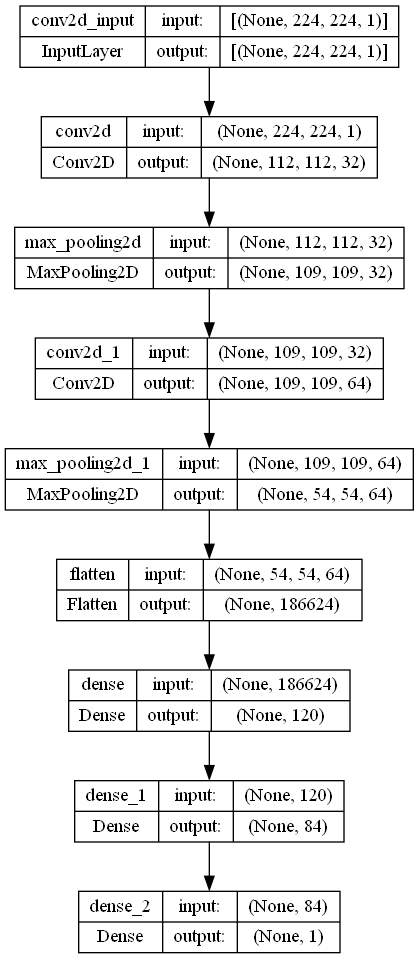

In [5]:
le_net_5 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding="same", input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    MaxPooling2D(pool_size=(4, 4), strides=1, padding="valid"),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding="same", activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
    # FLATTEN
    Flatten(),
    # DENSE LAYERS
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

IMG_PATH = './images'
print(le_net_5.summary())
plot_model(le_net_5, to_file=f'{IMG_PATH}/le_net_5.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      640       
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

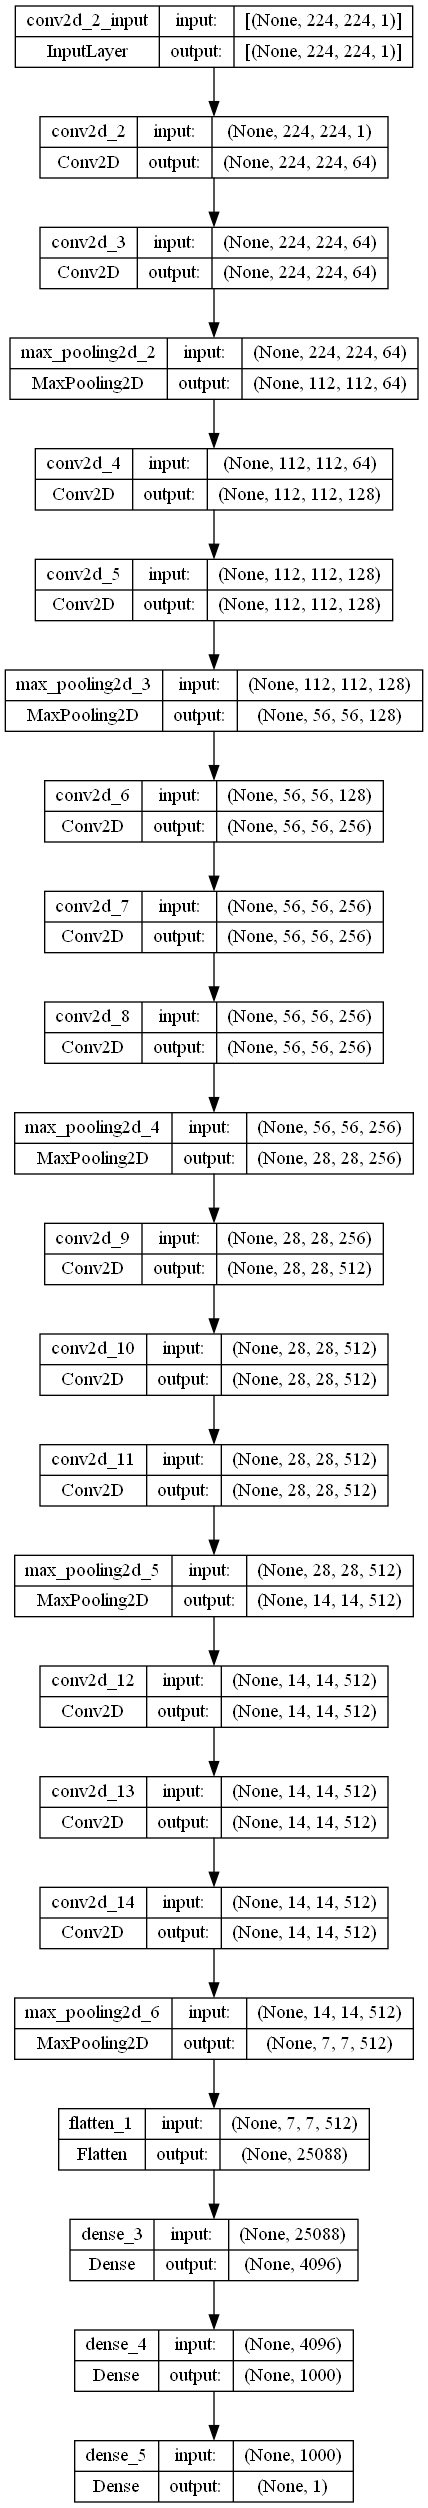

In [6]:
vgg_16 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 2
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 3
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 4
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 5
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # MAXPOOL BEFORE FC
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # FULLY CONNECTED LAYERS
    Flatten(),
    Dense(units=4096, activation='relu'),
    Dense(units=1000, activation='relu'),
    # OUTPUT LAYER
    Dense(units=1, activation='sigmoid')
])

print(vgg_16.summary())
plot_model(vgg_16, to_file=f'{IMG_PATH}/vgg_16.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

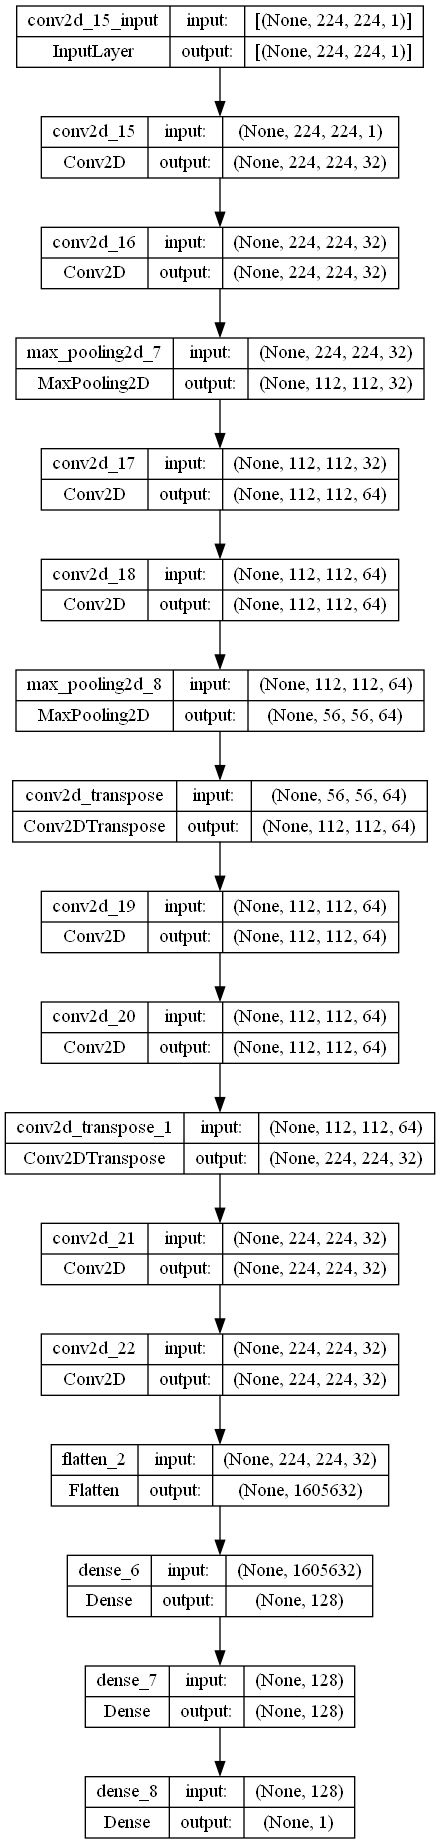

In [7]:
lu_net = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 3
    Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # LAYER 4
    Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # Fully connected layers
    Flatten(),
    Dense(units=128, activation='sigmoid'),
    Dense(units=128, activation='sigmoid'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

print(lu_net.summary())
plot_model(lu_net, to_file=f'{IMG_PATH}/lu_net.png', show_shapes=True, show_layer_names=True)

In [8]:
#opt = keras.optimizers.Adam(learning_rate=0.0003)
METRICS = [
    Precision(),
    BinaryAccuracy(),
    Recall(),
    balanced_accuracy
]

le_net_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
vgg_16.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
lu_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [4]:
def fit_evaluate(model, X_train, X_test, X_val, y_val, y_train, y_test, batch_size=32, epochs=100):
    res_model = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
    scores_model = model.evaluate(X_test, y_test)
    return res_model, scores_model

def graph_history(df, metrics):
    if len(metrics) == 1:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
        ax.plot(range(1, 101), df[metrics[0]], 'b-', label='Train')
        ax.plot(range(1, 101), df[f'val_{metrics[0]}'], 'r-', label='Validation')
        ax.set_title(metrics[0])
        ax.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(nrows=1, ncols=len(metrics), sharex=True, figsize=(30, 10))
        for i, metric in zip(range(len(metrics)), metrics):
            ax[i].plot(range(1, 101), df[metric], 'b-', label='Train')
            ax[i].plot(range(1, 101), df[f'val_{metric}'], 'r-', label='Validation')
            ax[i].set_title(metric)
            ax[i].legend()
        plt.show()

In [ ]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, X_val, y_val, y_train, y_test)

In [ ]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

In [ ]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['balanced_accuracy']
graph_history(df_le_net_5, metrics_1)
graph_history(df_le_net_5, metrics_2)

In [ ]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, X_val, y_val, y_train, y_test)

In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

In [ ]:
graph_history(df_vgg_16, metrics_1)
graph_history(df_vgg_16, metrics_2)

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, X_val, y_val, y_train, y_test)

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

In [ ]:
graph_history(df_lu_net, metrics_1)
graph_history(df_lu_net, metrics_2)

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
baccs = [score[4] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

In [ ]:
RES_PATH = './results'
scores_df.to_csv(f'{RES_PATH}/test_scores_1.csv')
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_1.csv')
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_1.csv')
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_1.csv')

## DATA AUGMENTATION

In [10]:
# X_yes, X_no, classes = load_dataset()
# X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X shape (220, 224, 224)
Num classes: 2


In [11]:
imgs_trans = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=0.25),
    A.Rotate(limit=[-20, 20], p=0.25, border_mode=cv2.BORDER_CONSTANT),
    A.Affine(translate_percent=(-0.05, 0.05))
])

X_train, y_train = data_augmentation(X_train, y_train, 20, imgs_trans)
X_val, y_val = data_augmentation(X_val, y_val, 20, imgs_trans)
X_test, y_test = data_augmentation(X_test, y_test, 20, imgs_trans)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

# X_aug, y_aug = data_augmentation(X, classes, 20, imgs_trans)
# X_aug, y_aug = np.array(X_aug), np.array(y_aug)

[!] 50 images agumented...
[!] 100 images agumented...
[!] Total of 123 images augmented!

[!] Total of 31 images augmented!

[!] 50 images agumented...
[!] Total of 66 images augmented!

X_train shape: (2460, 224, 224)
y_train shape (2460,)
X_val shape: (620, 224, 224)
y_val shape (620,)
X_test shape: (1320, 224, 224)
y_test shape: (1320,)


In [12]:
EPOCHS_2 = 60
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_2)

Epoch 1/100
77/77 [==============================] - 131s 2s/step - loss: 21.8006 - precision: 0.6091 - binary_accuracy: 0.5931 - recall: 0.9287 - balanced_accuracy: 0.5018 - val_loss: 0.5938 - val_precision: 0.6399 - val_binary_accuracy: 0.6403 - val_recall: 0.9447 - val_balanced_accuracy: 0.6232
Epoch 2/100
77/77 [==============================] - 132s 2s/step - loss: 0.6227 - precision: 0.6290 - binary_accuracy: 0.6321 - recall: 0.9673 - balanced_accuracy: 0.5389 - val_loss: 0.6078 - val_precision: 0.6359 - val_binary_accuracy: 0.6290 - val_recall: 0.9237 - val_balanced_accuracy: 0.6260
Epoch 3/100
77/77 [==============================] - 115s 1s/step - loss: 0.5684 - precision: 0.6706 - binary_accuracy: 0.6744 - recall: 0.9160 - balanced_accuracy: 0.6032 - val_loss: 0.5427 - val_precision: 0.7034 - val_binary_accuracy: 0.6790 - val_recall: 0.8237 - val_balanced_accuracy: 0.6785
Epoch 4/100
77/77 [==============================] - 115s 1s/step - loss: 0.4942 - precision: 0.7727 - bi

In [13]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,21.800558,0.609095,0.593089,0.928667,0.501792,0.593816,0.639929,0.640323,0.944737,0.623185
1,0.622718,0.628955,0.632114,0.967333,0.538900,0.607831,0.635870,0.629032,0.923684,0.626042
2,0.568402,0.670571,0.674390,0.916000,0.603205,0.542738,0.703371,0.679032,0.823684,0.678542
3,0.494214,0.772670,0.742276,0.818000,0.723054,0.535670,0.733796,0.712903,0.834211,0.712381
4,0.420923,0.813634,0.797967,0.867333,0.781528,0.582517,0.800000,0.711290,0.705263,0.728601


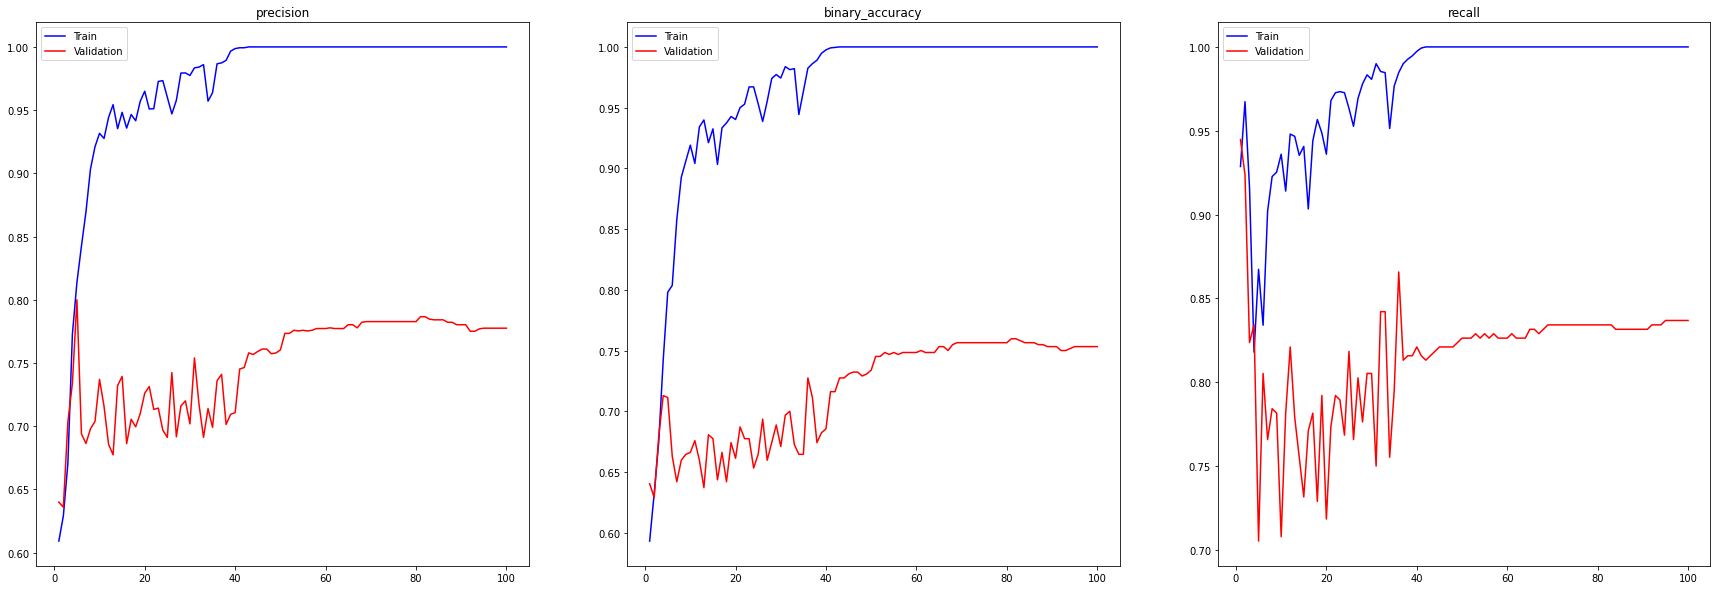

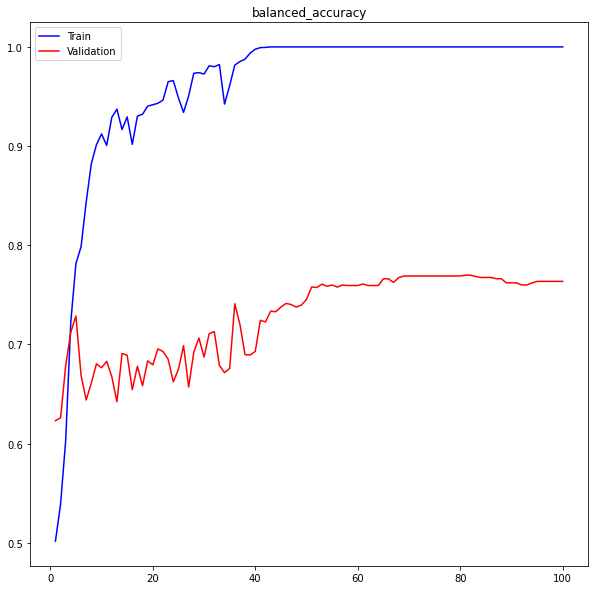

In [16]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['balanced_accuracy']
graph_history(df_le_net_5, metrics_1)
graph_history(df_le_net_5, metrics_2)

In [17]:
RES_PATH = './results'
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_2.csv')

In [ ]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_2)

In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

In [ ]:
graph_history(df_vgg_16, metrics_1)
graph_history(df_vgg_16, metrics_2)

In [ ]:
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_2.csv')

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_2)

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

In [ ]:
graph_history(df_lu_net, metrics_1)
graph_history(df_lu_net, metrics_2)

In [ ]:
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_2.csv')

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
baccs = [score[4] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

In [ ]:
scores_df.to_csv(f'{RES_PATH}/test_scores_2.csv')

## CNNs with L-2 regularization and Dropout layers

In [13]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [14]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True, stratify=classes)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=sd, shuffle=True, stratify=y_train)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (123, 224, 224)
y_train shape (123,)
X_val shape: (31, 224, 224)
y_val shape (31,)
X_test shape: (66, 224, 224)
y_test shape: (66,)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 112, 112, 32)      832       
                                                                 
 dropout_6 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 109, 109, 32)     0         
 2D)                                                             
                                                                 
 conv2d_24 (Conv2D)          (None, 109, 109, 64)      51264     
                                                                 
 dropout_7 (Dropout)         (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                 

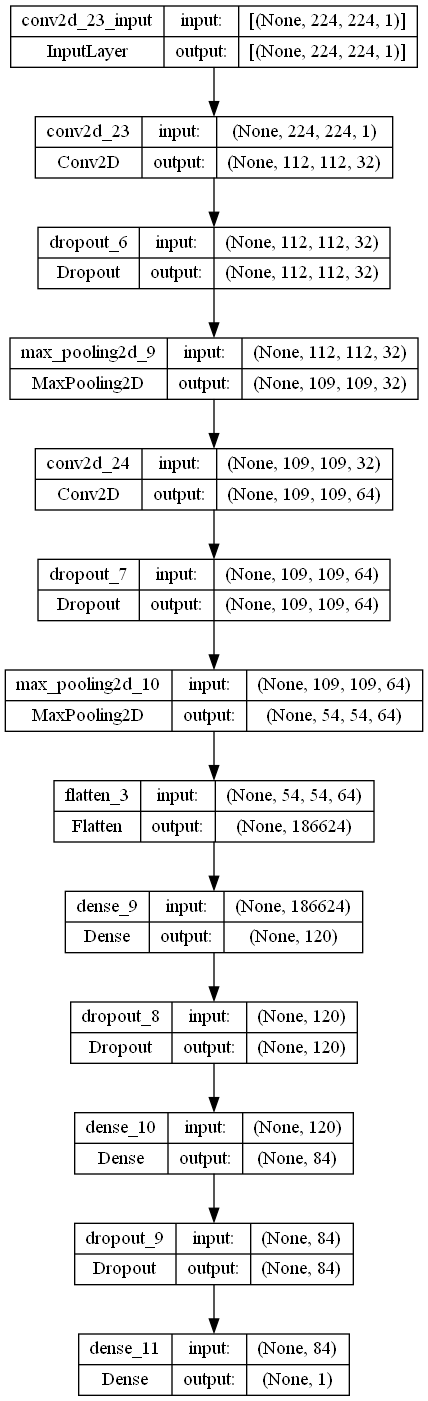

In [15]:
DROPOUT_RATE = 0.4
le_net_5 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding="same", input_shape=(SIZE_H, SIZE_V, 1), activation='relu', kernel_regularizer=L2(0.01)),
    Dropout(DROPOUT_RATE, seed=sd),
    MaxPooling2D(pool_size=(4, 4), strides=1, padding="valid"),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding="same", activation='relu', kernel_regularizer=L2(0.01)),
    Dropout(DROPOUT_RATE, seed=sd),
    MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
    # FLATTEN
    Flatten(),
    # DENSE LAYERS
    Dense(units=120, activation='relu'),
    Dropout(DROPOUT_RATE, seed=sd),
    Dense(units=84, activation='relu'),
    Dropout(DROPOUT_RATE, seed=sd),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

IMG_PATH = './images'
print(le_net_5.summary())
plot_model(le_net_5, to_file=f'{IMG_PATH}/le_net_5_dropout.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      640       
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

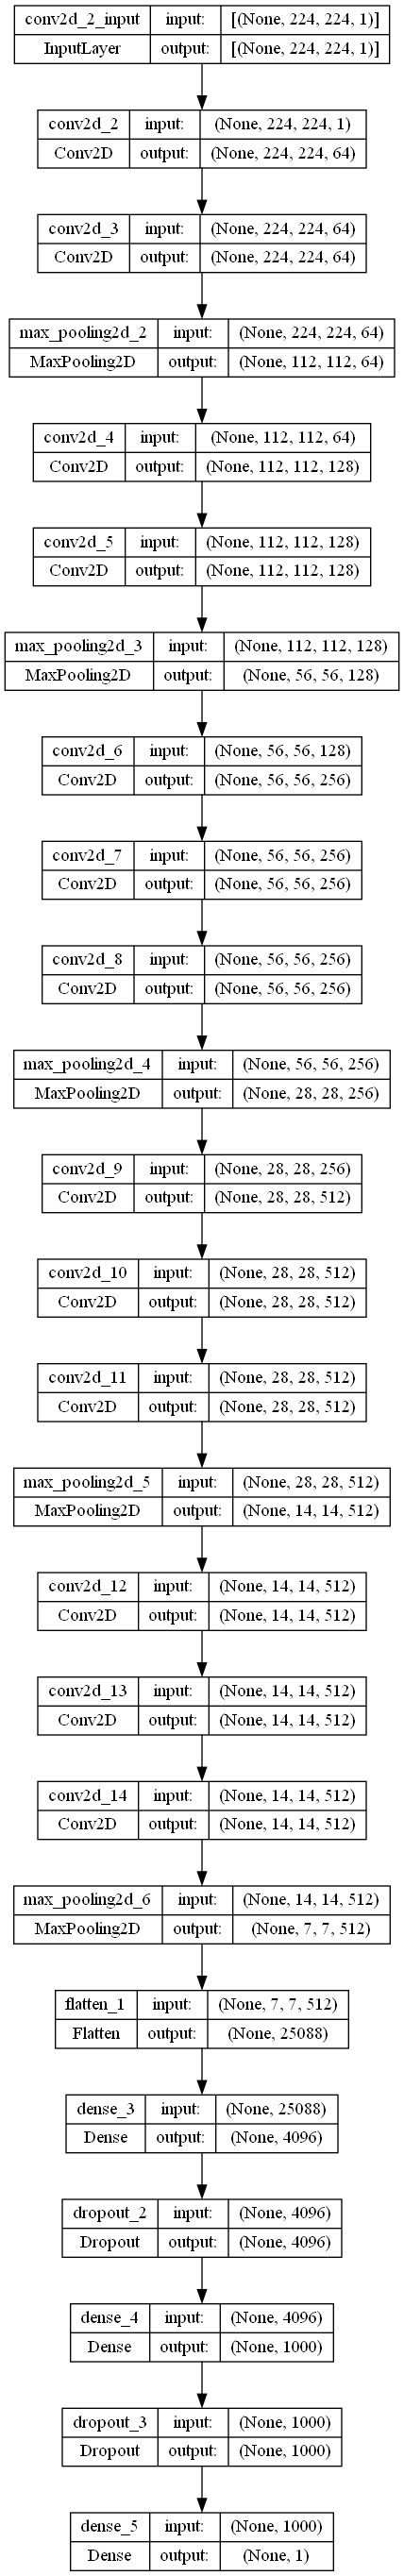

In [8]:
vgg_16 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    # LAYER 2
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    # LAYER 3
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    # LAYER 4
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    # LAYER 5
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    # MAXPOOL BEFORE FC
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # FULLY CONNECTED LAYERS
    Flatten(),
    Dense(units=4096, activation='relu'),
    Dropout(0.3),
    Dense(units=1000, activation='relu'),
    Dropout(0.3),
    # OUTPUT LAYER
    Dense(units=1, activation='sigmoid')
])

print(vgg_16.summary())
plot_model(vgg_16, to_file=f'{IMG_PATH}/vgg_16_dropout.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

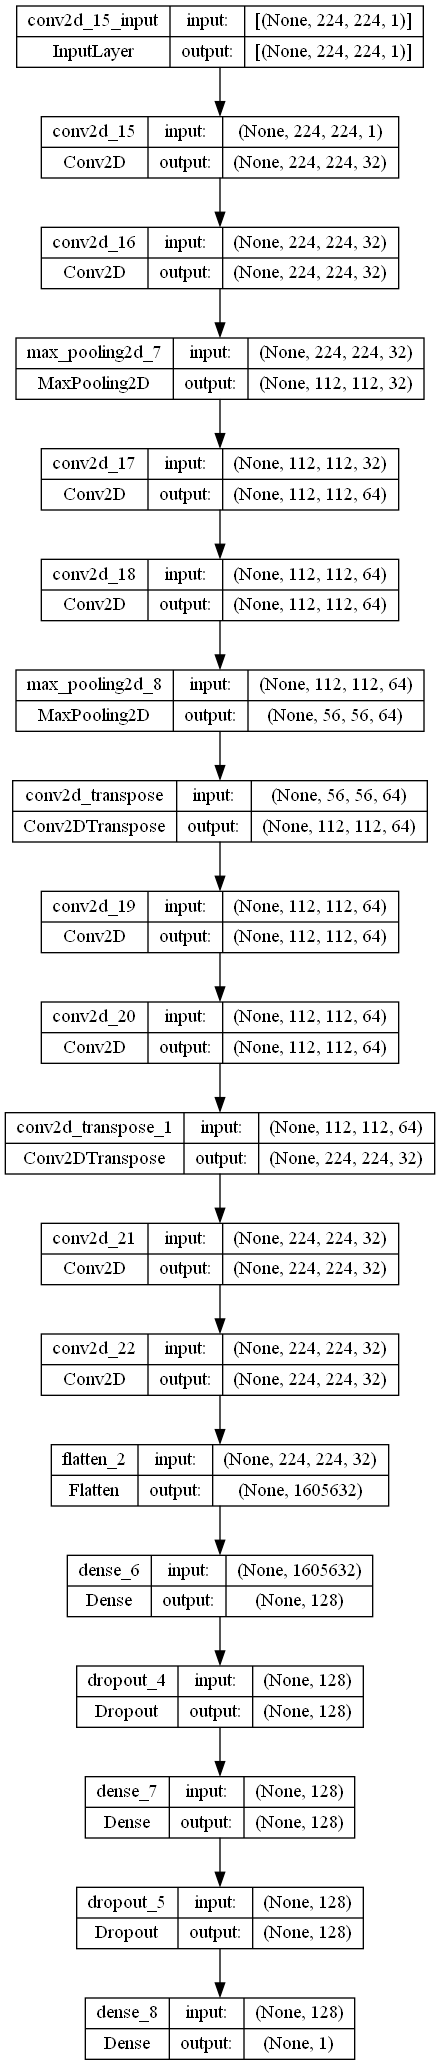

In [9]:
lu_net = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='elu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 3
    Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=2, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    # LAYER 4
    Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=2, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    # Fully connected layers
    Flatten(),
    Dense(units=128, activation='sigmoid'),
    Dropout(0.3),
    Dense(units=128, activation='sigmoid'),
    Dropout(0.3),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

print(lu_net.summary())
plot_model(lu_net, to_file=f'{IMG_PATH}/lu_net_dropout.png', show_shapes=True, show_layer_names=True)

In [11]:
METRICS = [
    Precision(),
    BinaryAccuracy(),
    Recall(),
    balanced_accuracy
]

le_net_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
vgg_16.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
lu_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [12]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, X_val, y_val, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 11s 2s/step - loss: 170.6179 - precision: 0.6250 - binary_accuracy: 0.4878 - recall: 0.4000 - balanced_accuracy: 0.5079 - val_loss: 13.0383 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 6s 2s/step - loss: 6.2152 - precision: 0.6000 - binary_accuracy: 0.5447 - recall: 0.7600 - balanced_accuracy: 0.4949 - val_loss: 1.0976 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 6s 2s/step - loss: 1.2849 - precision: 0.6562 - binary_accuracy: 0.6341 - recall: 0.8400 - balanced_accuracy: 0.5803 - val_loss: 1.1031 - val_precision: 0.6207 - val_binary_accuracy: 0.6129 - val_recall: 0.9474 - val_balanced_accuracy: 0.5154
Epoch 4/100
4/4 [==============================] - 6s 2s/step - loss: 1.0671 - precision: 0.6471 - binary_accuracy

KeyboardInterrupt: 

In [ ]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

In [ ]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['balanced_accuracy']
graph_history(df_le_net_5, metrics_1)
graph_history(df_le_net_5, metrics_2)

In [ ]:
RES_PATH = './results'
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_3.csv')

In [ ]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, X_val, y_val, y_train, y_test)

In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

In [ ]:
graph_history(df_vgg_16, metrics_1)
graph_history(df_vgg_16, metrics_2)

In [ ]:
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_3.csv')

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, X_val, y_val, y_train, y_test)

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

In [ ]:
graph_history(df_lu_net, metrics_1)
graph_history(df_lu_net, metrics_2)

In [ ]:
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_3.csv')

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
baccs = [score[4] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

In [ ]:
scores_df.to_csv(f'{RES_PATH}/test_scores_3.csv')